In [1]:
# import packages
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.linear_model import LinearRegression
import random
import scipy.stats as stats
# Import functions to plot lat/lon coordinate labels
import sys
sys.path.append('/data/keeling/a/dchug2/projects_final/S2SP_PPT_SM_Obs_2020/other_funcs')
from cartopy_coordinate_labels import (find_side, lambert_xticks, lambert_xticks_SA, 
                                       lambert_yticks, _lambert_ticks)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Polygon
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader, natural_earth
import matplotlib.patheffects as path_effects


In [2]:
# Get all initiations
startyear = 2018
endyear = 2018
#mon_arr = np.array([4])
mon_arr = np.array([6,7,8,9])
mon_dict = {1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'}

# Define the desired lat/lon bounds
latn = 30.
lats = 24.
lonw = 74.
lone = 78.

####### relevant directories
csvdir = '/data/keeling/a/dchug2/f/projects_final/nwindia_SM_convection/tracking/monthly_clouds/llax_correction//'
#savepath = '/data/keeling/a/dchug2/projects_final/mesoscale_SM_convection/codes/SMAP/results/control/'

year = startyear
counter = 0
while year<=endyear:
    for mon in mon_arr:
        try:
            # Read the csv file
            mondf = pd.read_csv(csvdir + str(year) + '_' + mon_dict[mon] + '_thres241_coolrate8.csv')
            # Check for lake mask at the initiation point
            #mondf = mondf[mondf['lake_mask'] == 0]
            # Filter for desired lat/lon bounds
            mondf = mondf[(mondf['lat']<latn) & (mondf['lat']>lats)]
            mondf = mondf[(mondf['lon']<lone) & (mondf['lon']>lonw)]
            # Preserve the old index as the identifier for events
            mondf['N'] = mondf.index
            # Create or append after ignoring old index
            if counter == 0:
                totaldf = mondf.copy()
                totaldf.reset_index(inplace = True)
            else:
                totaldf = totaldf.append(mondf, ignore_index = True)
            counter+=1
        except:
            pass
    year+=1
totaldf.drop('index', axis = 1, inplace = True)
totaldf.drop('N', axis = 1, inplace = True)
totaldf  

/tmp/ipykernel_120709/1855399351.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaldf = totaldf.append(mondf, ignore_index = True)
/tmp/ipykernel_120709/1855399351.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaldf = totaldf.append(mondf, ignore_index = True)
/tmp/ipykernel_120709/1855399351.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaldf = totaldf.append(mondf, ignore_index = True)


,time,Tb,lat,lon,lat_plax,lon_plax
0,2018-06-01 10:00:00,229.0,24.578533,75.248580,24.520257,75.150491
1,2018-06-02 13:00:00,235.0,24.796848,74.702910,24.741592,74.612680
2,2018-06-07 09:30:00,231.0,27.453000,74.993940,27.386493,74.893537
3,2018-06-07 10:00:00,235.0,27.271076,75.685135,27.205102,75.582087
4,2018-06-07 11:30:00,237.0,25.961193,76.158050,25.902850,76.061029
...,...,...,...,...,...,...
254,2018-09-21 10:00:00,237.0,25.924800,74.848420,25.866680,74.756674
255,2018-09-21 10:30:00,234.0,25.961193,74.884810,25.902971,74.792881
256,2018-09-22 07:30:00,239.0,28.471806,76.194430,28.406713,76.094456
257,2018-09-22 08:00:00,240.0,28.071560,76.194430,28.007580,76.094953


In [3]:
# Create lat and lon arrays and extract frequency in each bin
lat_arr = np.arange(latn,lats,-0.25)
lon_arr = np.arange(lonw, lone, 0.25)
CI_freq = np.zeros((np.size(lat_arr)-1,np.size(lon_arr)-1))

for i in range(len(lat_arr)-1):
    for j in range(len(lon_arr)-1):
        test = totaldf[totaldf['lat']>lat_arr[i+1]]
        test = test[test['lat']<=lat_arr[i]]
        test = test[test['lon']>=lon_arr[j]]
        test = test[test['lon']<lon_arr[j+1]]
        if len(test.index)>0:
            CI_freq[i,j] = len(test.index)

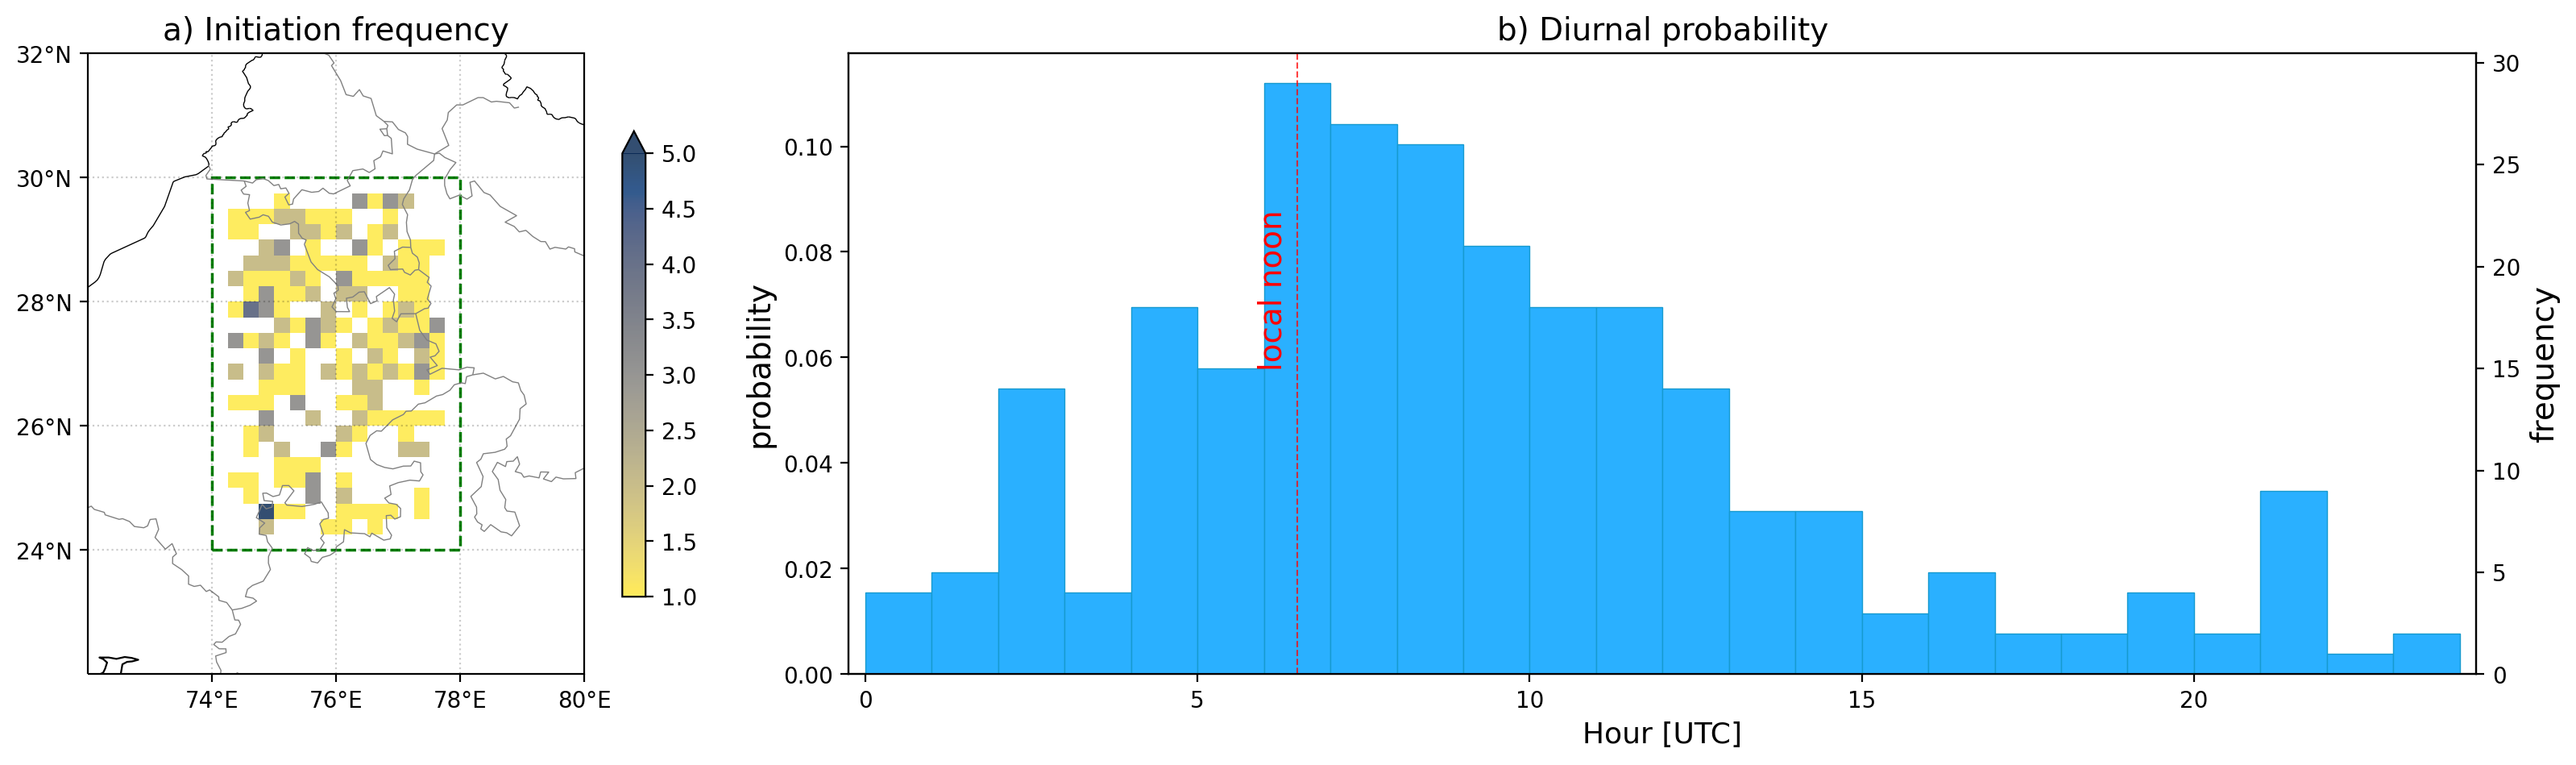

In [4]:
fig = plt.figure(figsize=(20, 5), dpi = 200)
grid = plt.GridSpec(1, 6, hspace=0.1, wspace = 0.35)

######## CI Frequency map ########
ax12 = fig.add_subplot(grid[0, 0:2], projection = ccrs.PlateCarree())

"""
Given 2-d arrays of elevation and regridded std dev of elevation, 
plot a shaded topographic complexity map overlayed with elevation contours.

*Output*
    Cartopy map figure
"""

ax12.set_xlim([lonw-2, lone+2])
ax12.set_ylim([lats-2,latn+2])

# Add borders and coastlines

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax12.add_feature(cfeature.BORDERS, linewidth = .5, edgecolor = "black")
ax12.add_feature(states_provinces, linewidth = .5, edgecolor = "grey")
ax12.coastlines('50m', linewidth = 0.8)
# Plot shaded contour of elevation data
clevels = [1,2,3,4,5]
             
CI_freq[CI_freq<1] = np.nan
CI_freq[CI_freq>5] = 6
pc = ax12.pcolormesh(lon_arr, lat_arr, CI_freq,
                   transform = ccrs.PlateCarree(),
                   vmin = 1, vmax = 5,
                   cmap = 'cividis_r', alpha = 0.8)

plt.colorbar(pc, ax=ax12, orientation = 'vertical', extend = 'max', 
             shrink = 0.75, pad = 0.05)


#clevels = [100, 150, 200, 250, 300]
#c = ax.contour(tc_lon, tc_lat, tc_data, transform = ccrs.PlateCarree(), 
#                levels = clevels, linewidths = 1., colors = 'k')
#ax.clabel(c, inline=True, fontsize=10)
# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [72,74,76,78,80]
yticks = [22,24,26,28,30,32]
ax12.gridlines(color = 'black', linestyle = 'dotted', xlocs = xticks, ylocs = yticks, alpha = 0.2)
# Label the end-points of the gridlines using the custom tick makers:
xticks = [72,74,76,78,80]
yticks = [22,24,26,28,30,32]
ax12.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax12.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax12, xticks)
lambert_yticks(ax12, yticks)
ax12.tick_params(axis='both', labelsize=10)
# Add shapefile for La Plata Basin
#fname = '/work/05825/tg851250/stampede2/Bluewaters/Laplata_tracers/lpb_shapefile/cuenca del plata geog.shp'
#shape_feature = ShapelyFeature(Reader(fname).geometries(), ccrs.PlateCarree(),
#                               edgecolor = 'green', facecolor = 'none')
#ax.add_feature(shape_feature, linewidth = 0.5)
# Add polygon to show the domain

newDomain = [(74.0, 24.0),
             (78.0, 24.0),
             (78.0, 30.0),
             (74.0, 30.0)]

poly = Polygon(newDomain, facecolor = 'None',
               linewidth = 1.25, edgecolor = 'green',
               linestyle = 'dashed')

plt.gca().add_patch(poly)

#fname = '/data/keeling/a/dchug2/WRF/intraseas_oscillation/LaPlataShapefile/cuenca del plata geog.shp'
#shape_feature = ShapelyFeature(Reader(fname).geometries(), ccrs.PlateCarree(),
#                               edgecolor = 'red', facecolor = 'none')

#ax12.add_feature(shape_feature, linewidth=1., alpha = 0.5)


#plt.gca().add_patch(poly)

# Add title
title1 = 'a) Initiation frequency' 
ax12.set_title(title1, fontsize=14,loc = 'center')

######## Diurnal Cycle ############
ax21 = fig.add_subplot(grid[0, 2:])

hour_data = pd.to_datetime(totaldf['time'].values).hour
bins = np.arange(0,25)

ax22 = ax21.twinx()
ax21.hist(hour_data, bins=bins, density=True)
ax22.hist(hour_data, bins=bins, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
ax22.set_ylabel('frequency', fontsize = 14)
ax21.set_ylabel('probability', fontsize = 14)
ax21.set_xlabel('Hour [UTC]', fontsize = 13)
ax21.set_xlim([-0.25,24.25])

trans = ax21.get_xaxis_transform()

x = 6.5
ax22.axvline(x,color = 'r', linewidth = 0.75, linestyle = '--', alpha = 0.75)
plt.text(x-0.6, .5, 'local noon', transform=trans, 
         rotation = 90, color = 'r', fontsize = 14)

title1 = 'b) Diurnal probability' 
ax21.set_title(title1, fontsize=14,loc = 'center')

pname = 'Diurnal_cycle_initiations.png'

plt.savefig('Figure_domain_initiations_thres241_coolrate8.png', bbox_inches='tight')
#ax.set_title('Linear Scale')][1]][1]

